# Import Libraries

In [1]:
import os
import pickle
import numpy as np
import deepdish as dd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr
from brainiak.eventseg.event import EventSegment
from sklearn.model_selection import train_test_split
import nibabel as nib

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, ttest_1samp
from statsmodels.stats.multitest import multipletests

from nilearn import plotting

/home/nalzahli/miniforge3/envs/buda/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


# Helper Functions

In [2]:
# Plot boundaries as boxes on top of timepoint correlation matrix
def plot_tt_similarity_matrix(ax, data_matrix, bounds, n_TRs, title_text):
    
    ax.imshow(np.corrcoef(data_matrix), cmap = 'viridis')
    ax.set_title(title_text)
    ax.set_xlabel('TR')
    ax.set_ylabel('TR')
    
    # plot the boundaries 
    bounds_aug = np.concatenate(([0], bounds, [n_TRs]))
    
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle(
            (bounds_aug[i], bounds_aug[i]),
            bounds_aug[i+1] - bounds_aug[i],
            bounds_aug[i+1] - bounds_aug[i],
            linewidth = 2, edgecolor = 'w',facecolor = 'none'
        )
        ax.add_patch(rect)

# Prepare Data

In [2]:
D_orig = dd.io.load('../data/SL/3446.h5')

In [3]:
D_orig['subj_0407161_predtrw02'].keys()

dict_keys(['Intact', 'SFix', 'SRnd'])

In [4]:
D_orig['subj_0407161_predtrw02']['Intact'].shape

(6, 60, 240)

In [8]:
len(D_orig.keys())

30

In [10]:
subject = list(D_orig.keys())[0]
N_vox = D_orig[subject]['Intact'].shape[2]

In [11]:
N_vox 

240

In [ ]:
D_orig = dd.io.load('data/SL/3446.h5')
D = np.zeros((30, 6, 60, 240))
for i,s in enumerate(D_orig.keys()):
    D[i] = D_orig[s]['Intact']
G = D.mean(0)

# Event Segmentation

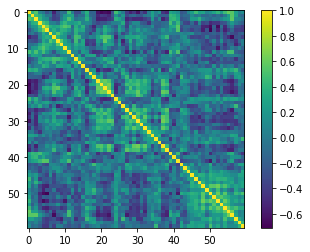

In [26]:
plt.imshow(np.corrcoef(D.mean(0)[0,:,:]))
plt.colorbar()

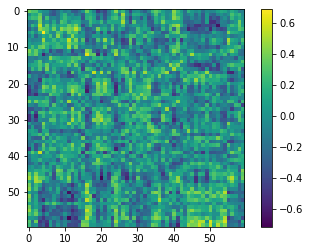

In [29]:
G1 = D[:15,0].mean(0)
G2 = D[15:,0].mean(0)
plt.imshow(np.corrcoef(G1,G2)[60:,:60])
plt.colorbar()

(array([ 9., 30., 40., 44., 36., 35., 23., 12.,  5.,  6.]),
 array([-0.02458543,  0.0460987 ,  0.11678284,  0.18746697,  0.25815111,
         0.32883524,  0.39951938,  0.47020351,  0.54088765,  0.61157178,
         0.68225592]),
 <BarContainer object of 10 artists>)

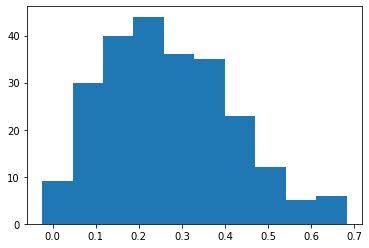

In [39]:
vox_ISC = np.diag(np.corrcoef(G1.T,G2.T)[:240,240:])
plt.hist(vox_ISC)

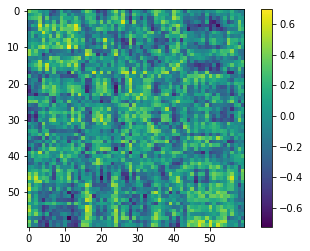

In [42]:
plt.imshow(np.corrcoef(G1[:,vox_ISC>0.2],G2[:,vox_ISC>0.2])[60:,:60])
plt.colorbar()

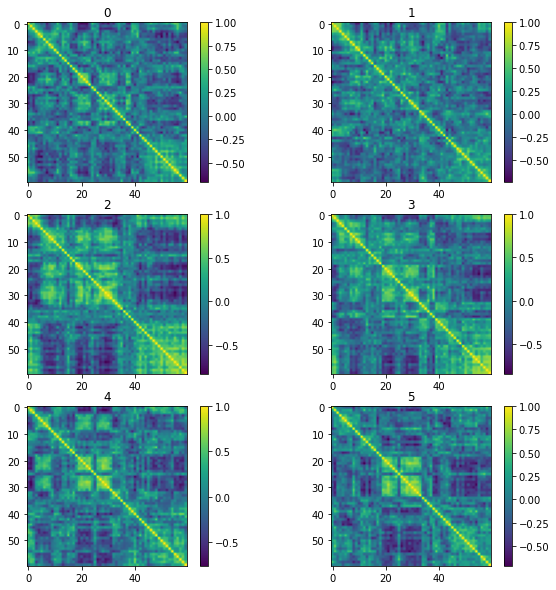

In [46]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(np.corrcoef(D.mean(0)[i,:,:]))
    plt.title(str(i))
    plt.colorbar()

# Successor Representation

In [78]:
HMM = EventSegment(7)

In [79]:
G = D.mean(0)
HMM.fit([G[i] for i in range(6)])

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0.]), n_events=7)

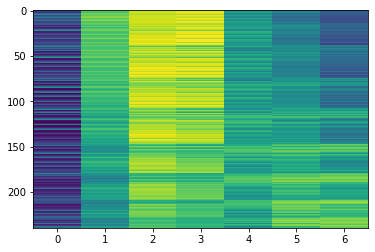

In [80]:
plt.imshow(HMM.event_pat_, aspect="auto", interpolation="None")

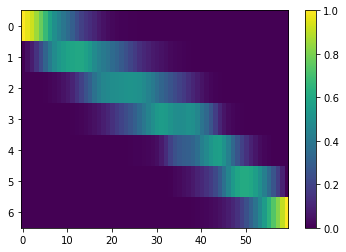

In [81]:
plt.imshow(HMM.segments_[0].T, aspect="auto", interpolation="None")
plt.colorbar()

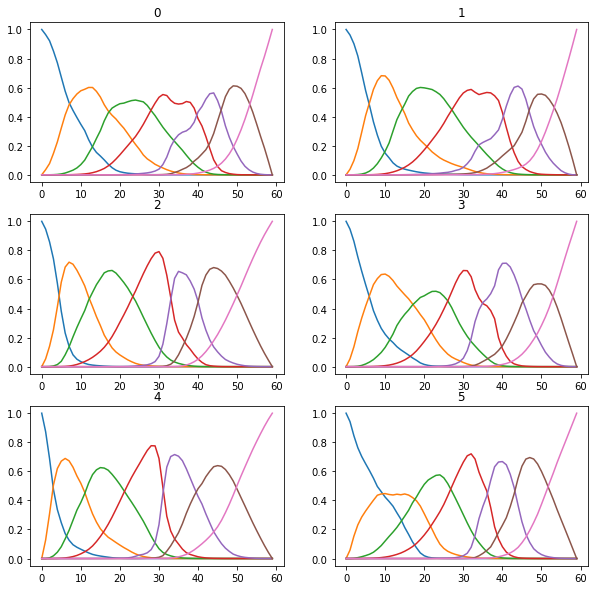

In [82]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.plot(HMM.segments_[i])
    plt.title(str(i))

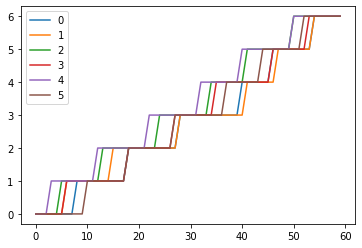

In [83]:
for i in range(6):
    plt.plot(np.argmax(HMM.segments_[i],axis=1))
plt.legend([str(i) for i in range(6)])

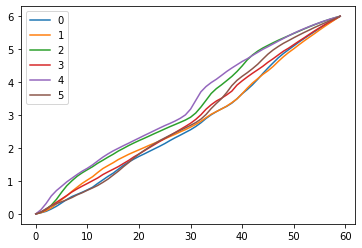

In [85]:
for i in range(6):
    plt.plot(HMM.segments_[i]@np.arange(7))
plt.legend([str(i) for i in range(6)])

# Changes in Event Segmentation

In [1]:
G = D.mean(0)

NameError: name 'D' is not defined

In [34]:
nEvents = np.arange(2,11)
HMMs = np.empty((len(nEvents),6), dtype=object)
for ev_i, ev in enumerate(nEvents):
    for repeat in range(6):
        HMMs[ev_i, repeat] = EventSegment(ev)
        HMMs[ev_i, repeat].fit(G[repeat]) # Should try with split-merge on

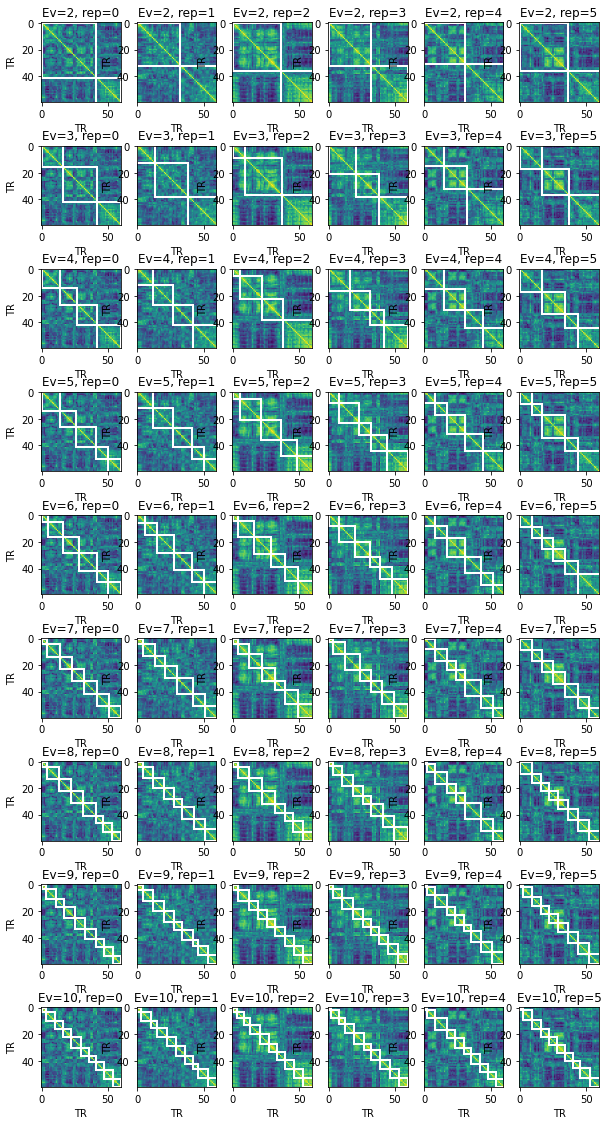

In [115]:
plt.figure(figsize=(10,20))
for ev_i, ev in enumerate(nEvents):
    for repeat in range(6):
        plt.subplot(len(nEvents),6,repeat+ev_i*6+1)
        bounds = np.where(np.diff(np.argmax(HMMs[ev_i,repeat].segments_[0],axis=1)))[0]
        plot_tt_similarity_matrix(plt.gca(), G[repeat], bounds, 60, "Ev="+str(ev)+", rep="+str(repeat))

# How to evaluate goodness of fit for each number of events?

How to evaluate goodness of fit for each number of events?

1) LL - need separate training/test set
    - See https://www.dpmlab.org/papers/elife-69430-v2.pdf  
    - Dtrain = data from 80% of subj
    - Dtest  = data from 20% of subj
    - hmm = brainiak.eventseg.event.EventSegment(n_events=k)
    - hmm.fit(Dtrain)
    - _, LL = hmm.find_events(Dtest)


2) Measure within vs between-event correlations
    - See https://www.dpmlab.org/papers/Neuron17.pdf
    - Measure correlation between all timepoints ~5 TRs apart
    - Bin these correlations based on whether they are within or between events
    - Maximize within- minus between-event

Correlations
- First on this SL, then whole-brain 
- First on Intact, then on other conditions

In [2]:
D_orig = dd.io.load('../data/SL/3446.h5')
D = np.zeros((30, 6, 60, 240))
for i,s in enumerate(D_orig.keys()):
    D[i] = D_orig[s]['Intact']
G = D.mean(0)

## Log Likelihood

### Basic Model

In [17]:
# 1) LL - need separate training/test set
# See https://www.dpmlab.org/papers/elife-69430-v2.pdf    
N_ppl = D.shape[0]
nEvents = np.arange(2,11)

test_size = 0.2 
train_indices, test_indices = train_test_split(np.arange(N_ppl),
                                          test_size=test_size, 
                                          random_state=42)

Gtrain = D[train_indices].mean(0)
Gtest  = D[test_indices].mean(0)

lls = np.empty((len(nEvents),6), dtype=object)

for ev_i, ev in enumerate(nEvents):
   for repeat in range(6):

      # multiple splits to avg over randomness (maybe 5-10)
      hmm = EventSegment(ev, split_merge=True)
      hmm.fit(Gtrain[repeat])
      _, LL = hmm.find_events(Gtest[repeat])
      lls[ev_i, repeat] = LL



### K-Fold

In [7]:
from sklearn.model_selection import KFold

N_ppl = D.shape[0]
nEvents = np.arange(2, 11)
n_splits = 5  # Number of folds for cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize an array to store the log-likelihoods for each event size, repeat, and fold
lls = np.empty((len(nEvents), 6, n_splits), dtype=object)

for ev_i, ev in enumerate(nEvents):
    for repeat in range(6):
        
        fold_idx = 0
        for train_indices, test_indices in kf.split(np.arange(N_ppl)):
            Gtrain = D[train_indices].mean(0)
            Gtest = D[test_indices].mean(0)

            hmm = EventSegment(ev, split_merge=True)
            hmm.fit(Gtrain[repeat])
            _, LL = hmm.find_events(Gtest[repeat])
            lls[ev_i, repeat, fold_idx] = LL

            fold_idx += 1

# Average across folds for each event size and repeat
avg_lls = lls.mean(axis=2)


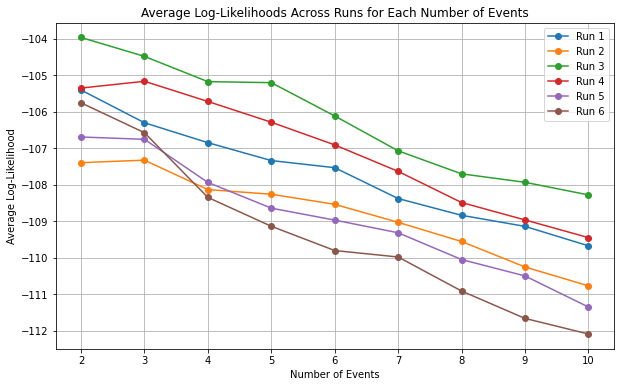

In [8]:
# Average Log-Likelihoods Across Repeats for Each Number of Events

plt.figure(figsize=(10, 6))

for repeat in range(6):
    plt.plot(nEvents, avg_lls[:, repeat],
            marker='o',
            label=f'Run {repeat + 1}')

plt.title("Average Log-Likelihoods Across Runs for Each Number of Events")
plt.xlabel("Number of Events")
plt.ylabel("Average Log-Likelihood")
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Event Segments')

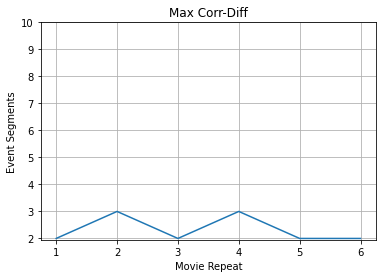

In [9]:
# Max LL for each event segmentation across repeats

plt.plot(1+np.arange(6), [2+np.argmax(avg_lls[:, repeat]) for repeat in range(6)])
plt.yticks(np.arange(2, 11, 1))
plt.grid()
plt.title("Max Corr-Diff")
plt.xlabel("Movie Repeat")
plt.ylabel("Event Segments")

### Cross Validated Model

In [3]:
N_ppl = D.shape[0]

nEvents = np.arange(2, 11)
num_splits = 5  # Number of splits for averaging
LLs = np.empty((len(nEvents), 6), dtype=object)
HMMs = np.empty((len(nEvents), 6), dtype=object)

val_size = 0.2
test_size = 0.2

train_val_indices, test_indices = train_test_split(np.arange(N_ppl),
                                test_size=test_size, 
                                random_state=42)

train_val = D[train_val_indices]
test  = D[test_indices].mean(0)

for ev_i, ev in enumerate(nEvents):
    for repeat in range(6):

        best_hmm = None
        best_ll = -float('inf')

        for i in range(num_splits):
            
            # Create a new split for each iteration
            train_val_ppl = train_val.shape[0]
            train_indices, val_indices = train_test_split(np.arange(train_val_ppl),
                                        test_size=val_size, 
                                        random_state=i)

            train = train_val[train_indices].mean(0)
            val  = train_val[val_indices].mean(0)

            # Fit and evaluate the model
            hmm = EventSegment(ev, split_merge=True)
            hmm.fit(train[repeat])
            _, ll = hmm.find_events(val[repeat])

            if ll > best_ll:
                best_ll = ll
                best_hmm = hmm

        # Calculate the average log-likelihood over the splits
        _, ll = best_hmm.find_events(test[repeat])
        LLs[ev_i, repeat] = ll
        HMMs[ev_i, repeat] = best_hmm

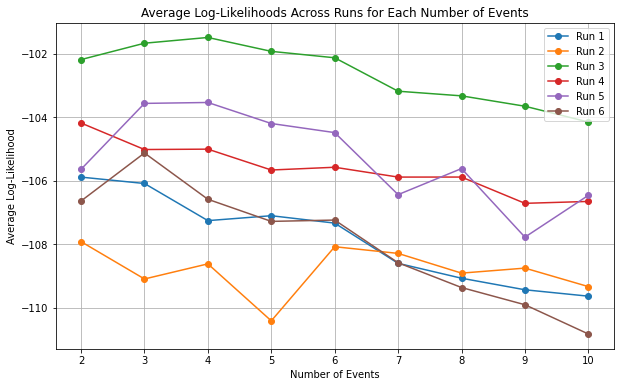

In [5]:
# Average Log-Likelihoods Across Repeats for Each Number of Events

plt.figure(figsize=(10, 6))

for repeat in range(6):
    plt.plot(nEvents, LLs[:, repeat],
            marker='o',
            label=f'Run {repeat + 1}')

plt.title("Average Log-Likelihoods Across Runs for Each Number of Events")
plt.xlabel("Number of Events")
plt.ylabel("Average Log-Likelihood")
plt.legend()
plt.grid(True)
plt.show()


Text(0, 0.5, 'Event Segments')

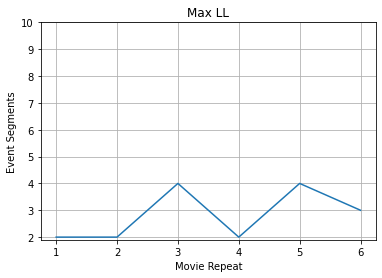

In [4]:
# Max LL for each event segmentation across repeats

plt.plot(1+np.arange(6), [2+np.argmax(LLs[:, repeat]) for repeat in range(6)])
plt.yticks(np.arange(2, 11, 1))
plt.grid()
plt.title("Max LL")
plt.xlabel("Movie Repeat")
plt.ylabel("Event Segments")


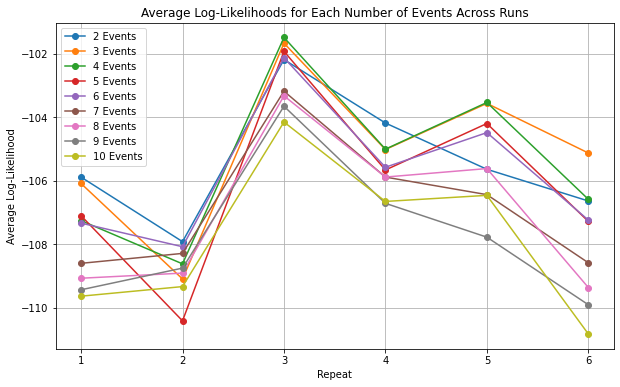

In [45]:
# Average Log-Likelihoods for Each Number of Events Across Repeats

plt.figure(figsize=(10, 6))

for ev_i, ev in enumerate(nEvents):
    plt.plot(range(1, 7), [LLs[ev_i, repeat] for repeat in range(6)], marker='o', label=f'{ev} Events')

plt.title("Average Log-Likelihoods for Each Number of Events Across Runs")
plt.xlabel("Repeat")
plt.ylabel("Average Log-Likelihood")
plt.xticks(range(1, 7)) 
plt.legend()
plt.grid(True)
plt.show()


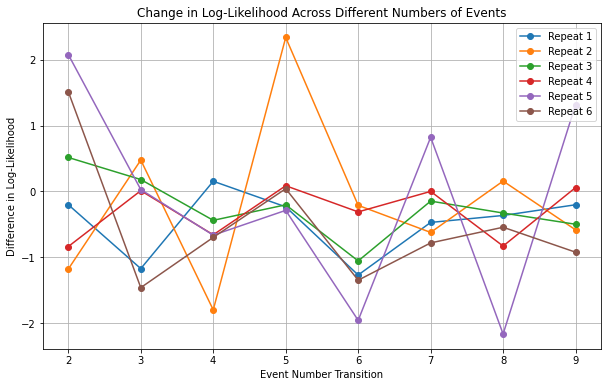

In [11]:
# Change in Log-Likelihood Across Different Numbers of Events

LL_diffs = np.diff(LLs, axis=0)

plt.figure(figsize=(10, 6))

# Assuming nEvents and LL_diffs are defined
for repeat in range(6):
    plt.plot(nEvents[:-1], LL_diffs[:, repeat],
             marker='o', label=f'Repeat {repeat + 1}')

plt.title("Change in Log-Likelihood Across Different Numbers of Events")
plt.xlabel("Event Number Transition")
plt.ylabel("Difference in Log-Likelihood")
plt.legend()
plt.grid(True)
plt.show()

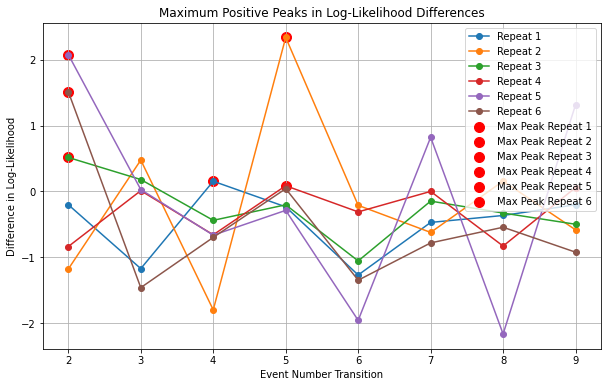

In [15]:
# Identifying positive peaks: significant improvement in model fit when moving from one numbr of events to the next

plt.figure(figsize=(10, 6))

for repeat in range(6):
    # Plotting the LL differences
    plt.plot(nEvents[:-1], LL_diffs[:, repeat],
             marker='o', label=f'Repeat {repeat + 1}')

    # Identifying and marking the maximum positive peak
    max_peak_value = np.max(LL_diffs[:, repeat])  # Find the maximum value
    max_peak_index = np.argmax(LL_diffs[:, repeat])  # Find the index of the maximum value
    
    # Ensure that the peak is positive
    if max_peak_value > 0:
        plt.scatter(nEvents[max_peak_index], max_peak_value, 
                    color='red', s=100, label=f'Max Peak Repeat {repeat + 1}')

plt.title("Maximum Positive Peaks in Log-Likelihood Differences")
plt.xlabel("Event Number Transition")
plt.ylabel("Difference in Log-Likelihood")
plt.legend()
plt.grid(True)
plt.show()


### Correct Cross Validated

In [4]:
N_ppl = D.shape[0]
nEvents = np.arange(2,11)

test_size = 0.5
num_splits = 5

LLs = np.empty((len(nEvents),6), dtype=object)

for ev_i, ev in enumerate(nEvents):
    for repeat in range(6):

        sum_LL = 0

        for _ in range(num_splits):

            train_indices, test_indices = train_test_split(np.arange(N_ppl),
                                            test_size=test_size, 
                                            random_state=42)

            train = D[train_indices].mean(0)
            test  = D[test_indices].mean(0)

            hmm = EventSegment(ev, split_merge=True)
            hmm.fit(train[repeat])
            _, LL = hmm.find_events(test[repeat])
            sum_LL += LL  
    
        LLs[ev_i, repeat] = sum_LL / num_splits

### e^ll stuff

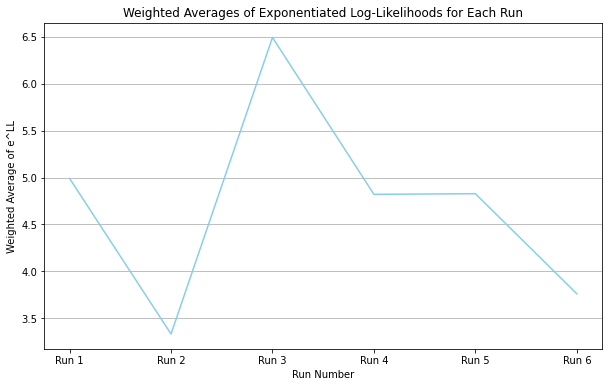

In [17]:
# Normalize LL values to avoid underflow when exponentiating
max_negative_ll = np.max(LLs)
normalized_lls = LLs + np.abs(max_negative_ll)

# Exponentiate the normalized LL values
exp_lls = np.empty((len(nEvents), 6), dtype=object)
for i in range(len(nEvents)):
    for j in range (6):
        exp_lls[i,j] = np.exp(normalized_lls[i,j])

# Initialize an array to store the weighted averages for each run
weighted_averages_per_run = np.empty(LLs.shape[1])

# Calculate the weighted average for each run
for run in range(LLs.shape[1]):
    weights = exp_lls[:, run]
    weighted_averages_per_run[run] = np.sum(weights * np.arange(2,11)) / np.sum(weights)

# Creating a bar chart
plt.figure(figsize=(10, 6))
plt.plot(range(6), weighted_averages_per_run, color='skyblue')

plt.title("Weighted Averages of Exponentiated Log-Likelihoods for Each Run")
plt.xlabel("Run Number")
plt.ylabel("Weighted Average of e^LL")
plt.xticks(range(6), [f'Run {i+1}' for i in range(6)])  

plt.grid(axis='y')
plt.show()


## Measure within vs between-event correlations

### Basic Model

In [16]:
# 2) Measure within vs between-event correlations
# See https://www.dpmlab.org/papers/Neuron17.pdf

# Measure correlation between all timepoints ~5 TRs apart
# Bin these correlations based on whether they are within or between events
# Maximize within- minus between-event correlations

num_timepoints = G.shape[1]
corr_diffs = np.empty((len(nEvents),6), dtype=object)

# train-test

test_size = 0.5

for ev_i, ev in enumerate(nEvents):
   for repeat in range(6):
        
        events = HMMs[ev_i, repeat].segments_[0]
        most_likely_event = np.argmax(events, axis=1)

        within_event_corrs = []
        between_event_corrs = []

        for i in range(num_timepoints - 5):

            # only one time point
            j = i+5  # Consider timepoints ~5 TRs apart
            corr, _ = pearsonr(G[repeat, i], G[repeat, j])
            if most_likely_event[i] == most_likely_event[j]:
                within_event_corrs.append(corr)
            else:
                between_event_corrs.append(corr)

        # Compute average correlations
        avg_within_event_corr = np.mean(within_event_corrs)
        avg_between_event_corr = np.mean(between_event_corrs)

        # Calculate the difference
        corr_diff = avg_within_event_corr - avg_between_event_corr
        corr_diffs[ev_i, repeat] = corr_diff

Text(0, 0.5, 'Correlation Difference')

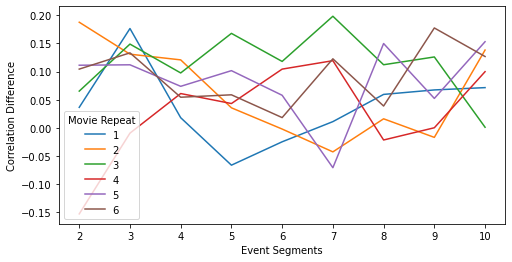

In [17]:
plt.figure(figsize=(8,4))
for repeat in range(6):
    plt.plot(np.arange(9) + 2, corr_diffs[:, repeat])
plt.legend([str(i+1) for i in range(6)], title="Movie Repeat")
plt.xlabel("Event Segments")
plt.ylabel("Correlation Difference")

Text(0, 0.5, 'Event Segments')

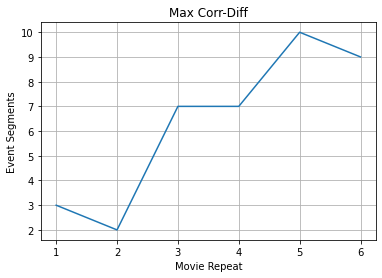

In [18]:
# e^corr_value --> 
plt.plot(1+np.arange(6), [2+np.argmax(corr_diffs[:, repeat]) for repeat in range(6)])
plt.yticks(np.arange(2, 11, 1))
plt.grid()
plt.title("Max Corr-Diff")
plt.xlabel("Movie Repeat")
plt.ylabel("Event Segments")

### Train-Test Model

In [6]:
num_timepoints = G.shape[1]
corr_diffs = np.empty((len(nEvents),6), dtype=object)

test_size = 0.5

for ev_i, ev in enumerate(nEvents):
    for repeat in range(6):

        train_indices, test_indices = train_test_split(np.arange(N_ppl),
                                            test_size=test_size, 
                                            random_state=42)

        train = D[train_indices].mean(0)
        test  = D[test_indices].mean(0)

        hmm = EventSegment(ev, split_merge=True)
        hmm.fit(train[repeat])
        
        events = hmm.segments_[0]
        most_likely_event = np.argmax(events, axis=1)

        within_event_corrs = []
        between_event_corrs = []

        for i in range(num_timepoints - 5):

            j = i+5  # Consider timepoints ~5 TRs apart
            corr, _ = pearsonr(test[repeat, i], test[repeat, j])
            if most_likely_event[i] == most_likely_event[j]:
                within_event_corrs.append(corr)
            else:
                between_event_corrs.append(corr)

        # Compute average correlations
        avg_within_event_corr = np.mean(within_event_corrs)
        avg_between_event_corr = np.mean(between_event_corrs)

        # Calculate the difference
        corr_diff = avg_within_event_corr - avg_between_event_corr
        corr_diffs[ev_i, repeat] = corr_diff



In [20]:
num_timepoints = G.shape[1]
corr_diffs = np.empty((len(nEvents),6), dtype=object)

test_size = 0.5

for ev_i, ev in enumerate(nEvents):
    for repeat in range(6):

        sum_corr_diff = 0

        for _ in range(num_splits):

            train_indices, test_indices = train_test_split(np.arange(N_ppl),
                                                test_size=test_size, 
                                                random_state=42)

            train = D[train_indices].mean(0)
            test  = D[test_indices].mean(0)

            hmm = EventSegment(ev, split_merge=True)
            hmm.fit(train[repeat])
            
            events = hmm.segments_[0]
            most_likely_event = np.argmax(events, axis=1)

            within_event_corrs = []
            between_event_corrs = []

            for i in range(num_timepoints - 5):

                j = i+5  # Consider timepoints ~5 TRs apart
                corr, _ = pearsonr(test[repeat, i], test[repeat, j])
                if most_likely_event[i] == most_likely_event[j]:
                    within_event_corrs.append(corr)
                else:
                    between_event_corrs.append(corr)

            # Compute average correlations
            avg_within_event_corr = np.mean(within_event_corrs)
            avg_between_event_corr = np.mean(between_event_corrs)

            # Calculate the difference
            corr_diff = avg_within_event_corr - avg_between_event_corr
            sum_corr_diff += corr_diff
        
        corr_diffs[ev_i, repeat] = sum_corr_diff / num_splits



Text(0, 0.5, 'Correlation Difference')

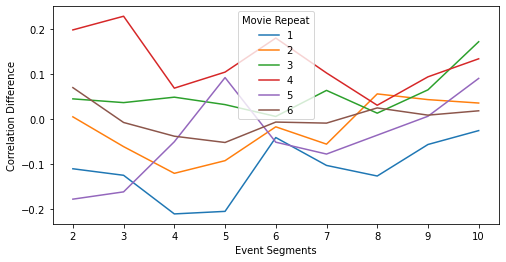

In [21]:
plt.figure(figsize=(8,4))
for repeat in range(6):
    plt.plot(np.arange(9) + 2, corr_diffs[:, repeat])
plt.legend([str(i+1) for i in range(6)], title="Movie Repeat")
plt.xlabel("Event Segments")
plt.ylabel("Correlation Difference")

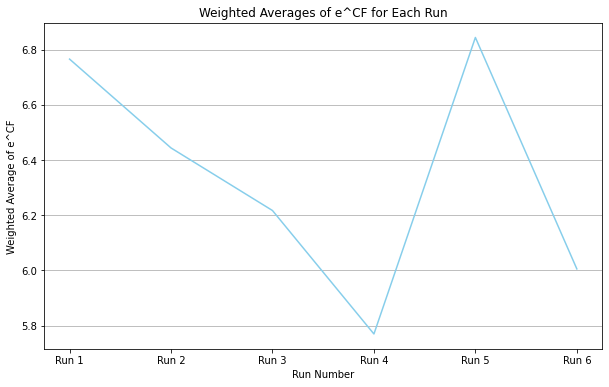

In [22]:
# Normalize LL values to avoid underflow when exponentiating
max_negative_cf = np.max(corr_diffs)
normalized_cfs = corr_diffs + np.abs(max_negative_cf)

# Exponentiate the normalized LL values
#exp_cfs = np.empty((len(nEvents), 6), dtype=object)
#for i in range(len(nEvents)):
    #for j in range (6):
        #exp_cfs[i,j] = np.exp(normalized_cfs[i,j])

# Initialize an array to store the weighted averages for each run
weighted_averages_per_run_cf = np.empty(corr_diffs.shape[1])

# Calculate the weighted average for each run
for run in range(corr_diffs.shape[1]):
    weights = normalized_cfs[:, run]
    weighted_averages_per_run_cf[run] = np.sum(weights * np.arange(2,11)) / np.sum(weights)

# Creating a bar chart
plt.figure(figsize=(10, 6))
plt.plot(range(6), weighted_averages_per_run_cf, color='skyblue')

plt.title("Weighted Averages of e^CF for Each Run")
plt.xlabel("Run Number")
plt.ylabel("Weighted Average of e^CF")
plt.xticks(range(6), [f'Run {i+1}' for i in range(6)])  

plt.grid(axis='y')
plt.show()


Text(0, 0.5, 'Event Segments')

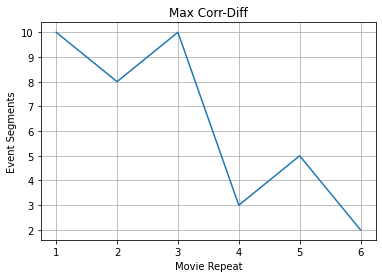

In [23]:
plt.plot(1+np.arange(6), [2+np.argmax(corr_diffs[:, repeat]) for repeat in range(6)])
plt.yticks(np.arange(2, 11, 1))
plt.grid()
plt.title("Max Corr-Diff")
plt.xlabel("Movie Repeat")
plt.ylabel("Event Segments")

# Across Subject Analysis

In [24]:
N_subj = D.shape[0]
N_voxels = D.shape[-1]
nEvents = np.arange(2,11)
test_size = 0.2
num_splits = 5

subj_LLs = {}

for subj in range(N_subj):

   lls = np.empty((len(nEvents),6), dtype=object)

   for ev_i, ev in enumerate(nEvents):
      for repeat in range(6):

         sum_ll = 0

         for _ in range(num_splits):

            train_indices, test_indices = train_test_split(np.arange(N_subj),
                                            test_size=test_size, 
                                            random_state=42)

            train = D[train_indices].mean(0)
            test  = D[test_indices].mean(0)

            hmm = EventSegment(ev, split_merge=True)
            hmm.fit(train[repeat])
            _, ll = hmm.find_events(test[repeat])
            sum_ll += ll
    
         lls[ev_i, repeat] = sum_ll / num_splits
      
   subj_LLs[subj] = lls

   



KeyboardInterrupt: 

In [ ]:
subj_weighted_averages_per_run = {}

for subj in range(N_subj):

    # Normalize LL values to avoid underflow when exponentiating
    max_negative_ll = np.max(subj_LLs[subj])
    normalized_lls = subj_LLs[subj] + np.abs(max_negative_ll)

    # Exponentiate the normalized LL values
    exp_lls = np.empty((len(nEvents), 6), dtype=object)
    for i in range(len(nEvents)):
        for j in range (6):
            exp_lls[i,j] = np.exp(normalized_lls[i,j])

    # Initialize an array to store the weighted averages for each run
    weighted_averages_per_run = np.empty(subj_LLs[subj].shape[1])

    # Calculate the weighted average for each run
    for run in range(subj_LLs[subj].shape[1]):
        weights = exp_lls[:, run]
        weighted_averages_per_run[run] = np.sum(weights * np.arange(2,11)) / np.sum(weights)

    subj_weighted_averages_per_run[subj] = weighted_averages_per_run

    # Creating a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(range(6), weighted_averages_per_run, color='skyblue')

    plt.title("Weighted Averages of Exponentiated Log-Likelihoods for Each Run for Subj {subj}")
    plt.xlabel("Run Number")
    plt.ylabel("Weighted Average of e^LL")
    plt.xticks(range(6), [f'Run {i+1}' for i in range(6)])  

    plt.grid(axis='y')
    plt.savefig(f'weighted_averages_per_run_{subj}.png')


In [ ]:
num_timepoints = G.shape[1]
corr_diffs = np.empty((len(nEvents),6), dtype=object)

# train-test

test_size = 0.5

for ev_i, ev in enumerate(nEvents):
   for repeat in range(6):
        
        events = HMMs[ev_i, repeat].segments_[0]
        most_likely_event = np.argmax(events, axis=1)

        within_event_corrs = []
        between_event_corrs = []

        for i in range(num_timepoints - 5):

            # only one time point
            j = i+5  # Consider timepoints ~5 TRs apart
            corr, _ = pearsonr(G[repeat, i], G[repeat, j])
            if most_likely_event[i] == most_likely_event[j]:
                within_event_corrs.append(corr)
            else:
                between_event_corrs.append(corr)

        # Compute average correlations
        avg_within_event_corr = np.mean(within_event_corrs)
        avg_between_event_corr = np.mean(between_event_corrs)

        # Calculate the difference
        corr_diff = avg_within_event_corr - avg_between_event_corr
        corr_diffs[ev_i, repeat] = corr_diff

# Whole Brain - Intact

## eLL

In [10]:
# Directory containing .h5 files
directory_path = 'data/SL/'

# Get all .h5 files in the directory
h5_files = [file for file in os.listdir(directory_path) if file.endswith('.h5')]
eLL = {}

for file in h5_files:
    # Construct the full file path
    file_path = os.path.join(directory_path, file)
    area_name = file.split('.')[0]
    
    # Load the data from the .h5 file
    D_orig = dd.io.load(file_path)
    vox_N = D_orig[list(D_orig.keys())[0]]['Intact'].shape[2]
    D = np.zeros((30, 6, 60, vox_N))
    for i, s in enumerate(D_orig.keys()):
        D[i] = D_orig[s]['Intact']

    G = D.mean(0)
    
    nEvents = np.arange(2,11)

    # Log-Likelihood
    N_subj = D.shape[0]
    split = int(0.5*N_subj)
    indxs = np.arange(N_subj)
    np.random.shuffle(indxs)

    Gtrain = D[indxs[:split]].mean(0)
    Gtest  = D[indxs[split:]].mean(0)

    lls = np.empty((len(nEvents),6), dtype=object)

    for ev_i, ev in enumerate(nEvents):
        for repeat in range(6):

            sum_LL = 0

            for _ in range(num_splits):

                train_indices, test_indices = train_test_split(np.arange(N_subj),
                                                test_size=test_size, 
                                                random_state=42)

                train = D[train_indices].mean(0)
                test  = D[test_indices].mean(0)

                hmm = EventSegment(ev, split_merge=True)
                hmm.fit(train[repeat])
                _, LL = hmm.find_events(test[repeat])
                sum_LL += LL
        
            LLs[ev_i, repeat] = sum_LL / num_splits

    # Normalize LL values to avoid underflow when exponentiating
    max_negative_ll = np.max(LLs)
    normalized_lls = LLs + np.abs(max_negative_ll)

    # Exponentiate the normalized LL values
    exp_lls = np.empty((len(nEvents), 6), dtype=object)
    for i in range(len(nEvents)):
        for j in range (6):
            exp_lls[i,j] = np.exp(normalized_lls[i,j])

    # Initialize an array to store the weighted averages for each run
    weighted_averages_per_run = np.empty(LLs.shape[1])

    # Calculate the weighted average for each run
    for run in range(LLs.shape[1]):
        weights = exp_lls[:, run]
        weighted_averages_per_run[run] = np.sum(weights * np.arange(2,11)) / np.sum(weights)

    eLL[area_name] = weighted_averages_per_run

    # Creating a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(range(6), weighted_averages_per_run, color='skyblue')

    plt.title("Weighted Averages of e^LL for Each Run - {area_name}")
    plt.xlabel("Run Number")
    plt.ylabel("Weighted Average of e^LL")
    plt.xticks(range(6), [f'Run {i+1}' for i in range(6)])  

    plt.grid(axis='y')
    plt.savefig(f'ell_{area_name}.png')


KeyboardInterrupt: 

/home/nalzahli/miniforge3/envs/buda/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/nalzahli/miniforge3/envs/buda/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/nalzahli/miniforge3/envs/buda/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much m

KeyboardInterrupt: 

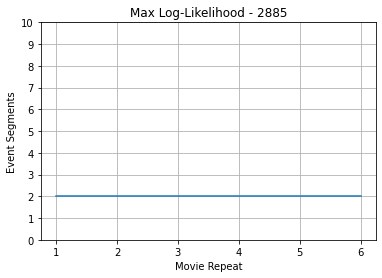

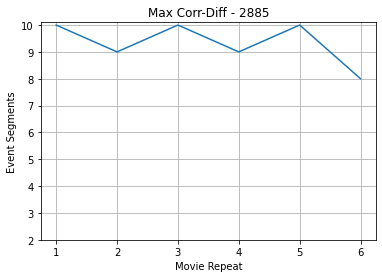

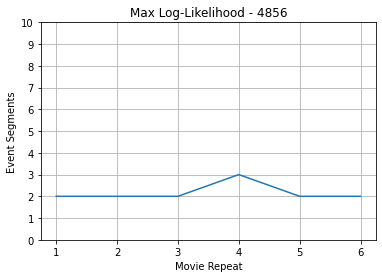

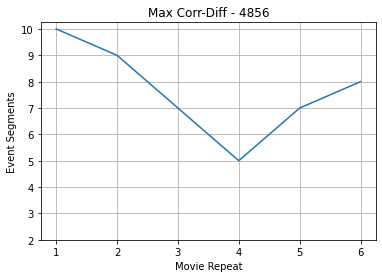

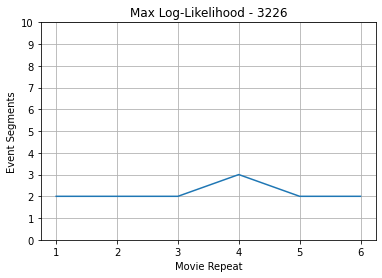

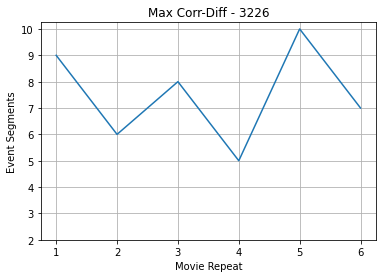

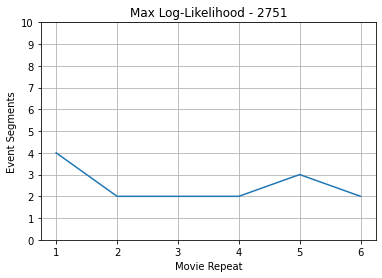

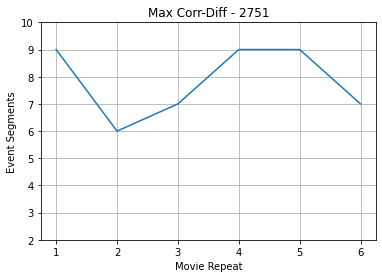

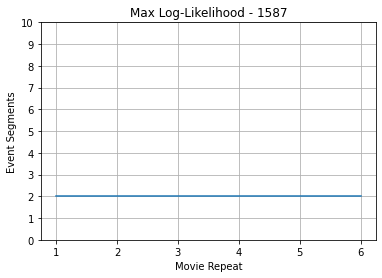

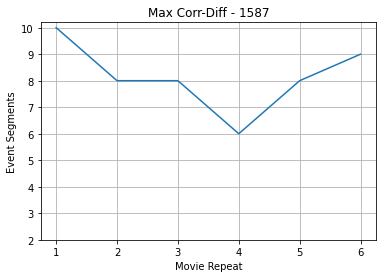

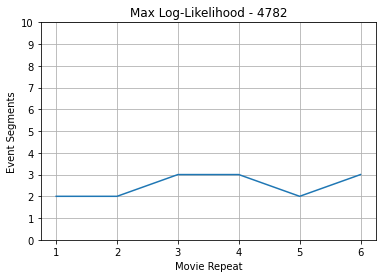

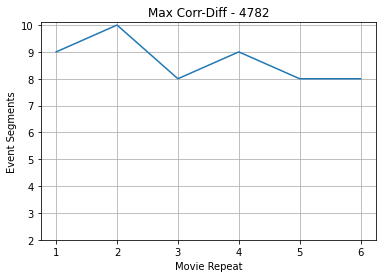

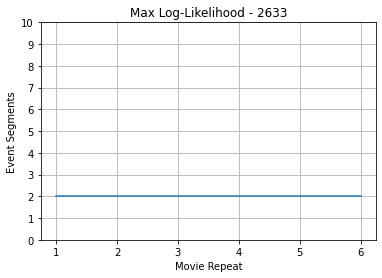

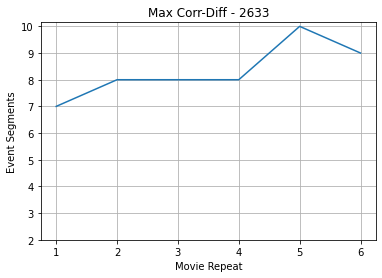

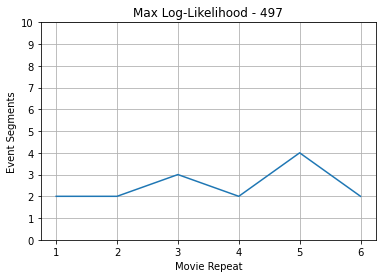

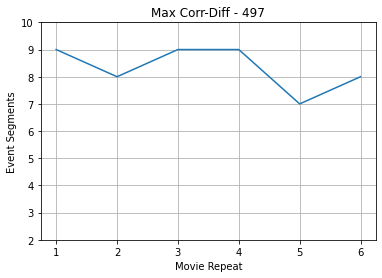

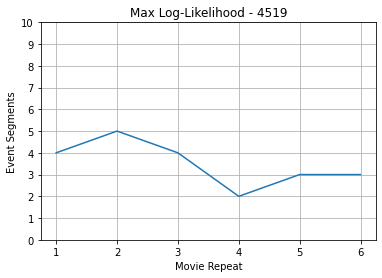

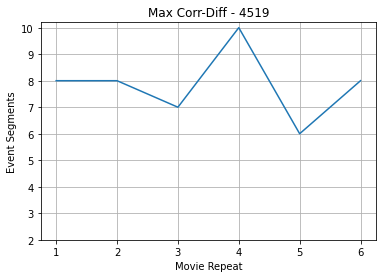

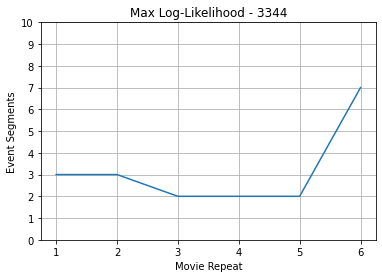

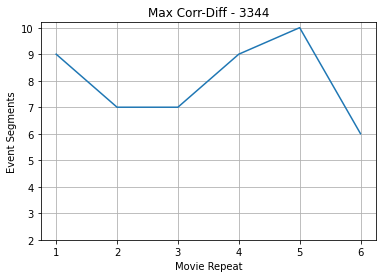

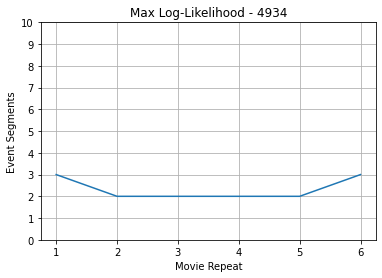

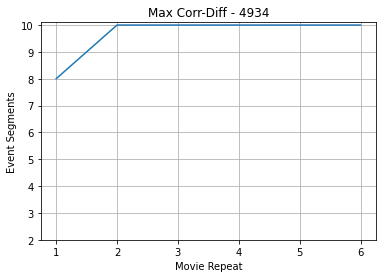

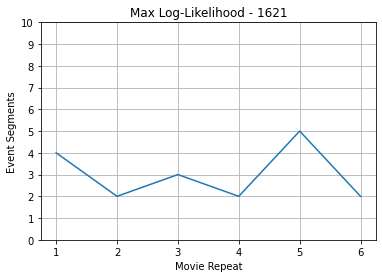

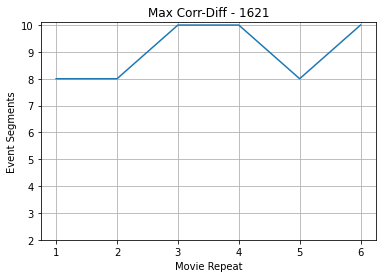

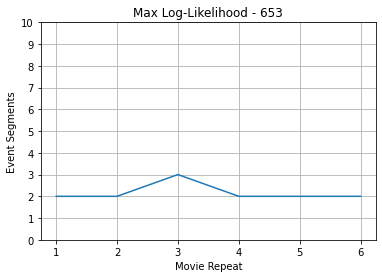

In [11]:
# Directory containing .h5 files
directory_path = 'data/SL/'

# Get all .h5 files in the directory
h5_files = [file for file in os.listdir(directory_path) if file.endswith('.h5')]

for file in h5_files:
    # Construct the full file path
    file_path = os.path.join(directory_path, file)
    area_name = file.split('.')[0]
    
    # Load the data from the .h5 file
    D_orig = dd.io.load(file_path)
    vox_N = D_orig[list(D_orig.keys())[0]]['Intact'].shape[2]
    D = np.zeros((30, 6, 60, vox_N))
    for i, s in enumerate(D_orig.keys()):
        D[i] = D_orig[s]['Intact']

    G = D.mean(0)

    nEvents = np.arange(2,11)

    # Log-Likelihood
    N = D.shape[0]
    split = int(0.5*N)
    indxs = np.arange(N)
    np.random.shuffle(indxs)

    Gtrain = D[indxs[:split]].mean(0)
    Gtest  = D[indxs[split:]].mean(0)

    lls = np.empty((len(nEvents),6), dtype=object)

    for ev_i, ev in enumerate(nEvents):
        for repeat in range(6):
            hmm = EventSegment(ev, split_merge=True)
            hmm.fit(Gtrain[repeat])
            _, LL = hmm.find_events(Gtest[repeat])
            lls[ev_i, repeat] = LL

            n_params = ev * (Gtrain.shape[-1] - 1)

    plt.figure()
    plt.plot(1+np.arange(6), [2+np.argmax(lls[:, repeat]) for repeat in range(6)])
    plt.yticks(np.arange(0, 11, 1))
    plt.grid()
    plt.title(f"Max Log-Likelihood - {area_name}")
    plt.xlabel("Movie Repeat")
    plt.ylabel("Event Segments")
    plt.savefig(f'LL_{area_name}.png')

    # Corr-Diff

    num_timepoints = G.shape[1]
    corr_diffs = np.empty((len(nEvents),6), dtype=object)
    HMMs = np.empty((len(nEvents),6), dtype=object)

    for ev_i, ev in enumerate(nEvents):
        for repeat in range(6):
            
            HMMs[ev_i, repeat] = EventSegment(ev, split_merge=True)
            HMMs[ev_i, repeat].fit(G[repeat])

            events = HMMs[ev_i, repeat].segments_[0]
            most_likely_event = np.argmax(events, axis=1)

            within_event_corrs = []
            between_event_corrs = []

            for i in range(num_timepoints):
                for j in range(i + 5, num_timepoints):  # Consider timepoints ~5 TRs apart
                    corr, _ = pearsonr(G[repeat, i], G[repeat, j])
                    if most_likely_event[i] == most_likely_event[j]:
                        within_event_corrs.append(corr)
                    else:
                        between_event_corrs.append(corr)

            # Compute average correlations
            avg_within_event_corr = np.mean(within_event_corrs)
            avg_between_event_corr = np.mean(between_event_corrs)

            # Calculate the difference
            corr_diff = avg_within_event_corr - avg_between_event_corr
            corr_diffs[ev_i, repeat] = corr_diff

    plt.figure()
    plt.plot(1+np.arange(6), [2+np.argmax(corr_diffs[:, repeat]) for repeat in range(6)])
    plt.yticks(np.arange(2, 11, 1))
    plt.grid()
    plt.title(f"Max Corr-Diff - {area_name}")
    plt.xlabel("Movie Repeat")
    plt.ylabel("Event Segments")
    plt.savefig(f'CD_{area_name}.png')


## corr diff

In [ ]:
import os
import numpy as np
import deepdish as dd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr
from brainiak.eventseg.event import EventSegment
from sklearn.model_selection import train_test_split

# Directory containing .h5 files
directory_path = '../data/SL/'

# Get all .h5 files in the directory
h5_files = [file for file in os.listdir(directory_path) if file.endswith('.h5')]
eWBC = {}
num_splits = 5
test_size = 0.5
nEvents = np.arange(2,11)

for file in h5_files:
    # Construct the full file path
    file_path = os.path.join(directory_path, file)
    area_name = file.split('.')[0]
    
    # Load the data from the .h5 file
    D_orig = dd.io.load(file_path)
    vox_N = D_orig[list(D_orig.keys())[0]]['Intact'].shape[2]
    D = np.zeros((30, 6, 60, vox_N))
    for i, s in enumerate(D_orig.keys()):
        D[i] = D_orig[s]['Intact']

    G = D.mean(0)

    # Log-Likelihood
    N_subj = D.shape[0]

    num_timepoints = G.shape[1]
    corr_diffs = np.empty((len(nEvents),6), dtype=object)

    test_size = 0.5

    for ev_i, ev in enumerate(nEvents):
        for repeat in range(6):

            train_indices, test_indices = train_test_split(np.arange(N_ppl),
                                            test_size=test_size, 
                                            random_state=42)

            train = D[train_indices].mean(0)
            test  = D[test_indices].mean(0)

            hmm = EventSegment(ev, split_merge=True)
            hmm.fit(train[repeat])
            
            events = hmm.segments_[0]
            most_likely_event = np.argmax(events, axis=1)

            within_event_corrs = []
            between_event_corrs = []

            for i in range(num_timepoints - 5):

                j = i+5  # Consider timepoints ~5 TRs apart
                corr, _ = pearsonr(test[repeat, i], test[repeat, j])
                if most_likely_event[i] == most_likely_event[j]:
                    within_event_corrs.append(corr)
                else:
                    between_event_corrs.append(corr)
            
                events = HMMs[ev_i, repeat].segments_[0]
                most_likely_event = np.argmax(events, axis=1)

            # Compute average correlations
            avg_within_event_corr = np.mean(within_event_corrs)
            avg_between_event_corr = np.mean(between_event_corrs)

            # Calculate the difference
            corr_diff = avg_within_event_corr - avg_between_event_corr
            corr_diffs[ev_i, repeat] = corr_diff

    # Exponentiate the normalized LL values
    exp_wbc = np.empty((len(nEvents), 6), dtype=object)
    for i in range(len(nEvents)):
        for j in range (6):
            exp_wbc[i,j] = np.exp(corr_diffs[i,j])

    # Initialize an array to store the weighted averages for each run
    weighted_averages_per_run = np.empty(corr_diffs.shape[1])

    # Calculate the weighted average for each run
    for run in range(LLs.shape[1]):
        weights = exp_wbc[:, run]
        weighted_averages_per_run[run] = np.sum(weights * np.arange(2,11)) / np.sum(weights)

    eWBC[area_name] = weighted_averages_per_run

# Save data to .npy file
np.save(f'eWBC.npy', eWBC)

## analysis

### ---maps

https://github.com/dpmlab/Anticipation-of-temporally-structured-events/blob/8fbd488c04d47148f9a53048de5d05a90e1c1663/s_light.py#L311

In [ ]:
# Load eLL.npy file / dictionary 
eLL = np.load('eLL.npy', allow_pickle=True).item()

# Number of valid voxels
non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
coords = np.transpose(np.where(non_nan_mask))
nVox = coords.shape[0]

nMaps = 6  # Number of movie repeats

# Indices of voxels belonging to each searchlight
SL_voxels = pickle.load(open('../data/SL/SL_allvox.p', 'rb'))

# Arrays for voxel maps and voxel searchlight count
voxel_maps = np.zeros((nMaps, nVox))
voxel_SLcount = np.zeros(nVox)

# Iterate over searchlights and voxels
for sl_idx, voxels_per_sl in enumerate(SL_voxels):
    for m in range(nMaps):
        voxel_maps[m, voxels_per_sl] += eLL[str(sl_idx)][m] # voxel gets all its sl contributions

    # Increment the count of searchlights for each voxel
    voxel_SLcount[voxels_per_sl] += 1

# Identify non-zero voxel counts
nz_vox = voxel_SLcount > 0

# Calculate voxel means based on searchlight contributions
voxel_maps[:, nz_vox] = voxel_maps[:, nz_vox] / voxel_SLcount[nz_vox]

# Set values for voxels with no searchlight contribution to NaN
voxel_maps[:, ~nz_vox] = np.nan

#### steps

In [4]:
non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
coords = np.transpose(np.where(non_nan_mask))
nVox = coords.shape[0]

nMaps = 6  # Number of movie repeats

In [5]:
nVox

518527

In [6]:
# Voxel information from searchlight analysis
SL_voxels = pickle.load(open('../data/SL/SL_allvox.p', 'rb'))

In [7]:
len(SL_voxels)

5354

In [25]:
SL_voxels[0]

array([ 513,  514,  515,  516,  517,  568,  569,  570,  571,  572,  573,
        574,  621,  622,  623,  624,  625,  669,  670,  671,  672,  673,
        713, 1000])

In [8]:
# Arrays for voxel maps and voxel searchlight count
voxel_maps = np.zeros((nMaps, nVox))
voxel_SLcount = np.zeros(nVox)

In [9]:
eLL = {}

for i in range(5354):
    eLL[f'{i}'] = np.array([1, 2, 3, 4, 5, 6])

In [10]:
# Iterate over searchlights and voxels
for sl_idx, sl_voxs in enumerate(SL_voxels):
    for m in range(nMaps):
        voxel_maps[m, sl_voxs] += eLL[str(sl_idx)][m]

    # Increment the count of searchlights for each voxel
    voxel_SLcount[sl_voxs] += 1

In [11]:
# Identify non-zero voxel counts
nz_vox = voxel_SLcount > 0

# Calculate voxel means based on searchlight contributions
voxel_maps[:, nz_vox] = voxel_maps[:, nz_vox] / voxel_SLcount[nz_vox]

# Set values for voxels with no searchlight contribution to NaN
voxel_maps[:, ~nz_vox] = np.nan

### ---one vs. other

In [12]:
# The first voxel map for movie repeat #1
group1 = voxel_maps[0, :]

# Average of the rest of the voxel maps for movie repeats [2,6]
group2 = np.mean(voxel_maps[1:, :], axis=0)

# Independent t-test to compare the two groups
t_statistic, p_value = ttest_ind(group1, group2)

print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print('There is a statistically significant difference between the groups')
else:
    print('There is no statistically significant difference between the groups')



T-Statistic: -inf
P-Value: 0.0
There is a statistically significant difference between the groups


### ---correlation: time_scales[1,6] & range(1,6)

In [ ]:
# Create a range of values from 1 to 6
range_values = np.arange(1, 7)

# Correlation coefficients and p_values for each voxel
correlations = np.zeros(voxel_maps.shape[1])
p_values = np.zeros(voxel_maps.shape[1])

# Calculate correlations and t-tests for every voxel
for voxel_index in range(voxel_maps.shape[1]):
    timescale_values = voxel_maps[:, voxel_index]  # Extract timescale values for voxel
    
    # Calculate Pearson's corr coeff
    correlation, _ = pearsonr(timescale_values, range_values)
    correlations[voxel_index] = correlation  # Store corr coeff

    # Fisher transformation to calculate t-statistics and p-values
    fisher_transformed_corr = 0.5 * np.log((1 + correlation) / (1 - correlation))
    n = voxel_maps.shape[0]
    t_statistic = fisher_transformed_corr / (1 / np.sqrt(n - 3))
    p_value = 2 * (1 - t_statistic)
    p_values[voxel_index] = p_value

# Multi comparisons Bonferroni correction
significance = 0.05
corrected_p_values = multipletests(p_values, alpha=significance, method='bonferroni')[1]

# Identify signif corr
signif_correlations = correlations[corrected_p_values < significance]

# Indices of voxels with signif corr
signif_voxel_indices = np.where(corrected_p_values < significance)[0]


In [ ]:
# Create a range of values from 1 to 6
range_values = np.arange(1, 7)

# Correlation coefficients and p_values for each voxel
correlations = np.zeros(voxel_maps.shape[1])
p_values = np.zeros(voxel_maps.shape[1])

# Iterate over voxels to calculate correlations
for voxel_index in range(voxel_maps.shape[1]):
    timescale_values = voxel_maps[:, voxel_index]  # Extract timescale values for voxel
    correlation, _ = pearsonr(timescale_values, range_values)  # Calculate Pearson's corr coeff
    correlations[voxel_index] = correlation  # Store corr coeff
    
    # One-sample t-test for each correlation coefficient (against zero)
    t_statistic, p_value = ttest_1samp(correlation, popmean=0)
    p_values[voxel_index] = p_value

# Multi comparisons Bonferroni correction
significance = 0.05
corrected_p_values = multipletests(p_values, alpha=significance, method='bonferroni')[1]

# Identify signif corr
signif_correlations = correlations[corrected_p_values < significance]

# Indices of voxels with signif corr
signifi_voxel_indices = np.where(corrected_p_values < significance)[0]


### ---visualizations

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import plotting

# Create an empty brain image (3D) with the same dimensions as your data
# You may need to load a reference anatomical image to get the affine transformation
# Replace 'anatomical_image.nii.gz' with the path to your anatomical image
anat_img = nib.load('anatomical_image.nii.gz')
empty_img = nib.Nifti1Image(np.zeros(anat_img.shape), anat_img.affine)

# Create a mask using the significant voxel indices
mask_data = np.zeros(anat_img.shape)
mask_data[significant_voxel_indices] = 1
mask_img = nib.Nifti1Image(mask_data, anat_img.affine)

# Create a plot of the voxel_map on the empty brain image using the mask
for i in range(6):
    plotting.plot_stat_map(nib.Nifti1Image(voxel_maps[i,:], anat_img.affine),
                        cut_coords=(0, 0, 0),  # Coordinate for slicing the brain
                        display_mode='ortho',  # Display in orthogonal view
                        title='Voxel Map',
                        bg_img=empty_img,  # Empty brain image
                        threshold=0.0,  # Adjust
                        cmap='viridis',  # Colormap
                        colorbar=True)

plotting.show()


# ROIs - Scrambled

In [ ]:
# Directory containing .h5 files
directory_path = 'data/SL/'

# Get all .h5 files in the directory
h5_files = [file for file in os.listdir(directory_path) if file.endswith('.h5')]

for file in h5_files:
    # Construct the full file path
    file_path = os.path.join(directory_path, file)
    area_name = file.split('.')[0]
    
    # Load the data from the .h5 file
    D_orig = dd.io.load(file_path)
    vox_N = D_orig[list(D_orig.keys())[0]]['Intact'].shape[2]
    D = np.zeros((30, 6, 60, vox_N))
    for i, s in enumerate(D_orig.keys()):
        D[i] = D_orig[s]['SFix']

    G = D.mean(0)

    nEvents = np.arange(2,11)

    # Log-Likelihood
    N = D.shape[0]
    split = int(0.5*N)
    indxs = np.arange(N)
    np.random.shuffle(indxs)

    Gtrain = D[indxs[:split]].mean(0)
    Gtest  = D[indxs[split:]].mean(0)

    lls = np.empty((len(nEvents),6), dtype=object)

    for ev_i, ev in enumerate(nEvents):
        for repeat in range(6):
            hmm = EventSegment(ev, split_merge=True)
            hmm.fit(Gtrain[repeat])
            _, LL = hmm.find_events(Gtest[repeat])
            lls[ev_i, repeat] = LL

            n_params = ev * (Gtrain.shape[-1] - 1)

    plt.figure()
    plt.plot(1+np.arange(6), [2+np.argmax(lls[:, repeat]) for repeat in range(6)])
    plt.yticks(np.arange(0, 11, 1))
    plt.grid()
    plt.title(f"Max Log-Likelihood - {area_name}")
    plt.xlabel("Movie Repeat")
    plt.ylabel("Event Segments")

    # Corr-Diff

    num_timepoints = G.shape[1]
    corr_diffs = np.empty((len(nEvents),6), dtype=object)

    for ev_i, ev in enumerate(nEvents):
        for repeat in range(6):
            
            events = HMMs[ev_i, repeat].segments_[0]
            most_likely_event = np.argmax(events, axis=1)

            within_event_corrs = []
            between_event_corrs = []

            for i in range(num_timepoints):
                for j in range(i + 5, num_timepoints):  # Consider timepoints ~5 TRs apart
                    corr, _ = pearsonr(G[repeat, i], G[repeat, j])
                    if most_likely_event[i] == most_likely_event[j]:
                        within_event_corrs.append(corr)
                    else:
                        between_event_corrs.append(corr)

            # Compute average correlations
            avg_within_event_corr = np.mean(within_event_corrs)
            avg_between_event_corr = np.mean(between_event_corrs)

            # Calculate the difference
            corr_diff = avg_within_event_corr - avg_between_event_corr
            corr_diffs[ev_i, repeat] = corr_diff

    plt.figure()
    plt.plot(1+np.arange(6), [2+np.argmax(corr_diffs[:, repeat]) for repeat in range(6)])
    plt.yticks(np.arange(2, 11, 1))
    plt.grid()
    plt.title(f"Max Corr-Diff - {area_name}")
    plt.xlabel("Movie Repeat")
    plt.ylabel("Event Segments")
